In [2]:
import pandas as pd
import numpy as np
from methods import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product

/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Bad key "text.kerning_factor" on line 4 in
/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Metrics calculation

In [27]:
DATA_PATH = "data2/data_tu-helpfulness-of-xai_2022-06-29_10-48.xlsx"
DATA_PREPARED_PATH = f"{DATA_PATH.split('.')[0]}_PREPARED.{DATA_PATH.split('.')[1]}"
df = pd.read_excel(DATA_PATH)
df_merged = pd.read_excel(DATA_PREPARED_PATH)

In [28]:
df_quest_meta = pd.read_excel("data2/question_meta_data.xlsx")

## Metrics on all images (fixed + random)

### Overall ability to guess model is correct if actually correct

In [29]:
num_guessed_correct_if_correct = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == True)].shape[0]
num_correct_overall = df_merged[df_merged["is_pred_correct"] == True].shape[0]

In [30]:
num_guessed_correct_if_correct / num_correct_overall

0.6268382352941176

### Overall ability to guess model is wrong if actually wrong

In [31]:
num_guessed_wrong_if_wrong = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == False)].shape[0]
num_wrong_overall = df_merged[df_merged["is_pred_correct"] == False].shape[0]

In [32]:
num_guessed_wrong_if_wrong / num_wrong_overall

0.5471813725490197

### Ability for each XAI-method to guess model is correct/wrong if actually correct/wrong

In [33]:
def create_individual_ratios(df_merged):
    df_ratios_per_method = df_merged.groupby(by=["method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [35]:
df_ratios_per_method = create_individual_ratios(df_merged)

In [36]:
df_ratios_per_method

,method,is_pred_correct,response,ratio
0,ConfidenceScores,False,False,0.647059
1,ConfidenceScores,True,True,0.750000
2,IntegratedGradients,False,False,0.511029
3,IntegratedGradients,True,True,0.555147
4,LIME,False,False,0.503676
5,LIME,True,True,0.588235
6,LRP,False,False,0.426471
7,LRP,True,True,0.742647
8,SHAP,False,False,0.775735
9,SHAP,True,True,0.341912


In [37]:
def plot_ratios(df_ratios_per_method, title_addition=""):        
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"], c="orange", label="Guessed Correct when Model Correct")
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"], c="purple", label="Guessed Wrong when Model Wrong")
    ax.plot(df_ratios_per_method["method"], [0.5] * len(df_ratios_per_method), color="red", linestyle='dashed', label="baseline")
    ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_ratios_per_method["ratio"].round(2)):
        ax.annotate(txt, (list(df_ratios_per_method["method"])[i], list(df_ratios_per_method["ratio"])[i]))
    ax.legend(loc="best", edgecolor="black")

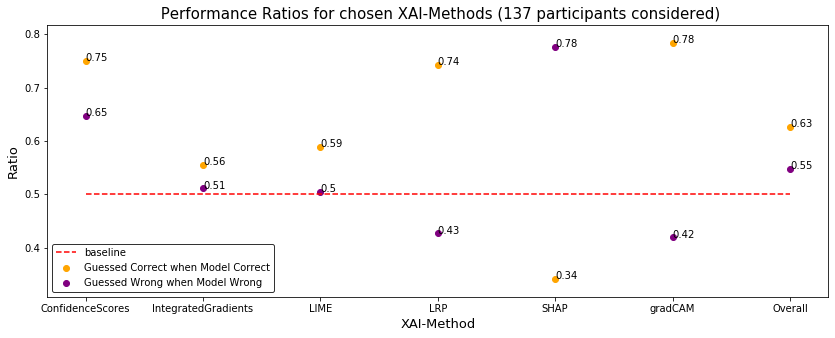

In [38]:
plot_ratios(df_ratios_per_method)

## Metrics only on fixed images

In [39]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

In [40]:
df_merged_fixed = df_merged[df_merged["img_idx"].isin(fixed_img_idxs)]

In [41]:
df_ratios_per_method_fixed = create_individual_ratios(df_merged_fixed)

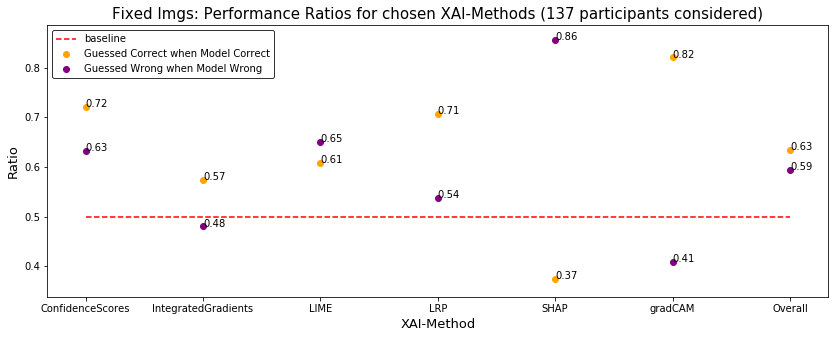

In [42]:
plot_ratios(df_ratios_per_method_fixed, "Fixed Imgs:")

## Convergence of ratio values as more participant results are taken into account

In [43]:
def create_individual_ratios_per_participant(df_merged):
    # df_schema needed to get all TP,TN,FP,FN i.e. where value_counts() would evaluate nothing because not existent (0)
    df_schema = pd.DataFrame(list(product(df_merged["case"].drop_duplicates(), df_merged["method"].drop_duplicates(), df_merged["is_pred_correct"].drop_duplicates(), df_merged["response"].drop_duplicates()))).groupby([0, 1, 2, 3]).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=['case', 'method', 'is_pred_correct', 'response']
    df_ratios_per_method_and_part = df_merged.groupby(by=["case", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method_and_part = df_schema.merge(right=df_ratios_per_method_and_part, on=["case", "method", "is_pred_correct", "response"], how="left")
    df_ratios_per_method_and_part = df_ratios_per_method_and_part.fillna(0)
    # only filter for TP and TP (just for now, might get modified)
    df_ratios_per_method_and_part = df_ratios_per_method_and_part[df_ratios_per_method_and_part["is_pred_correct"] == df_ratios_per_method_and_part["response"]].reset_index(drop=True)
    return df_ratios_per_method_and_part.groupby(by=["method", "is_pred_correct"]).expanding().mean()#.reset_index(level=2, drop=True)
    #return df_ratios_per_method_and_part
    
    # df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]

In [44]:
df_ratios_convergence = create_individual_ratios_per_participant(df_merged)
df_ratios_convergence

case  response     ratio
method           is_pred_correct                                      
ConfidenceScores False           0      579.000000       0.0  1.000000
                                 12     580.000000       0.0  0.500000
                                 24     582.333333       0.0  0.500000
                                 36     584.000000       0.0  0.500000
                                 48     588.200000       0.0  0.600000
...                                            ...       ...       ...
gradCAM          True            1583  1123.303030       1.0  0.791667
                                 1595  1127.293233       1.0  0.789474
                                 1607  1131.238806       1.0  0.783582
                                 1619  1135.140741       1.0  0.785185
                                 1631  1139.000000       1.0  0.783088

[1632 rows x 3 columns]

In [45]:
def plot_ratio_convergence(df_ratios_convergence):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Ratio", size=13)
    ax.set_title("Convergence of Ratios as Ratios are calculated over increasing Numbers of Participants", size=15)
    for method in df_ratios_convergence.index.get_level_values(0).drop_duplicates():
        for outcome in df_ratios_convergence.index.get_level_values(1).drop_duplicates():
            ax.plot(list(range(len(df_ratios_convergence.loc[method, outcome]))), df_ratios_convergence.loc[method, outcome]["ratio"], label=f"{method}, {outcome}")
            # print(df_ratios_convergence.loc[method, outcome]["ratio"].iloc[-1])
    ax.legend(loc="lower center", edgecolor="black")

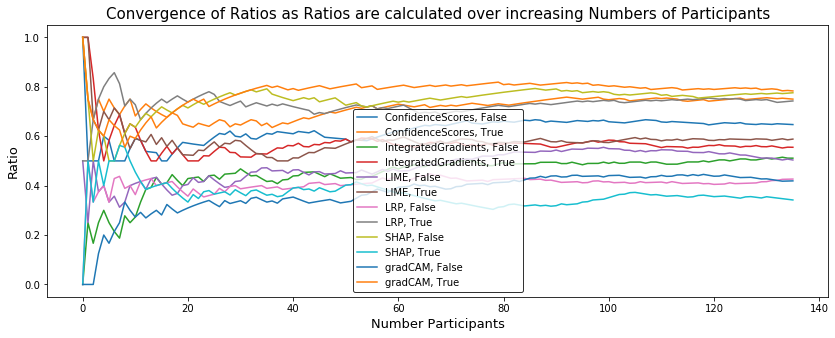

In [46]:
plot_ratio_convergence(df_ratios_convergence, )

## Metrics per questionnaire form (detect outlier questionaires)

In [50]:
def create_individual_ratios_per_questionnaire(df_merged):
    df_ratios_per_method = df_merged.groupby(by=["QUESTNNR", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [111]:
df_ratios_qustn = create_individual_ratios_per_questionnaire(df_merged)

In [112]:
def plot_ratios_per_questionnaire(df_ratios_qustn):
    df_ratios_qustn = df_ratios_qustn.set_index(["method", "is_pred_correct"])
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  


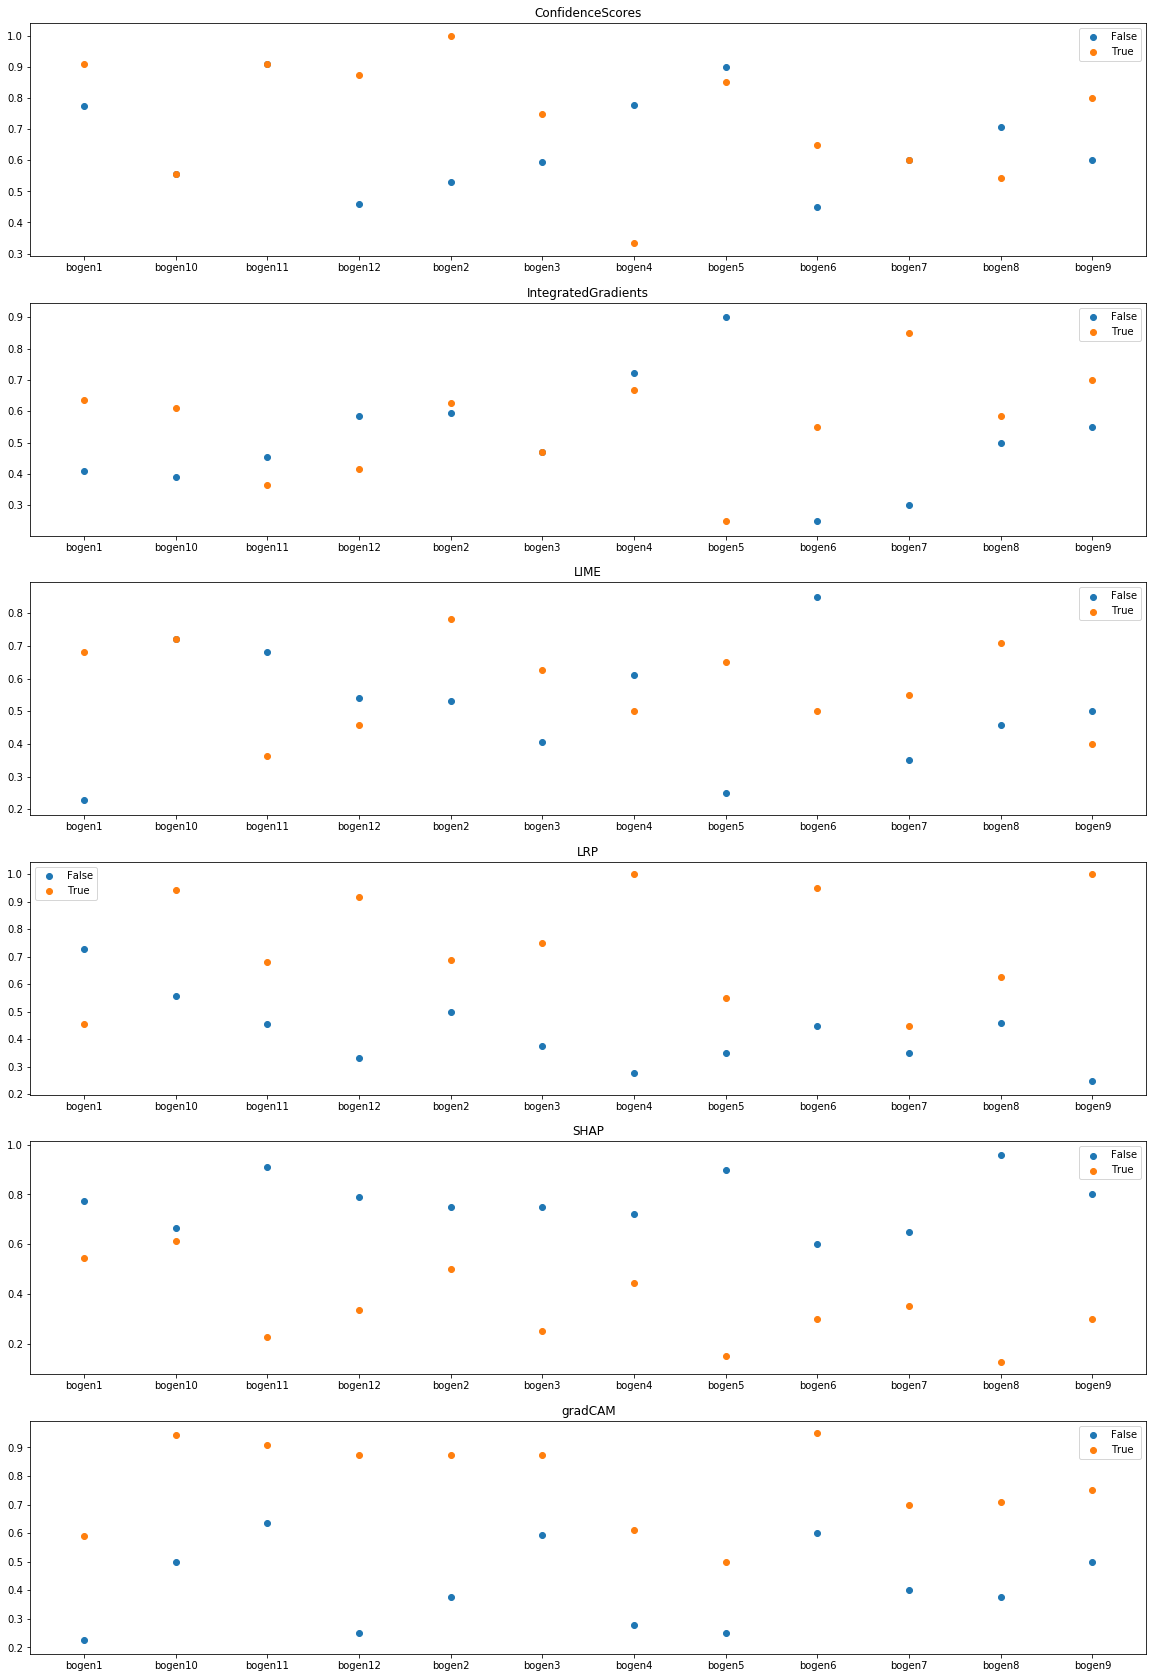

In [113]:
plot_ratios_per_questionnaire(df_ratios_qustn)

In [104]:
def plot_boxplot_over_qnrs_per_method(df_ratios_qustn):
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

,QUESTNNR,response,ratio
is_pred_correct,,,
False,bogen1,False,0.409091
True,bogen1,True,0.636364
False,bogen10,False,0.388889
True,bogen10,True,0.611111
False,bogen11,False,0.454545
True,bogen11,True,0.363636
False,bogen12,False,0.583333
True,bogen12,True,0.416667
False,bogen2,False,0.593750


Text(0, 0.5, 'Test')

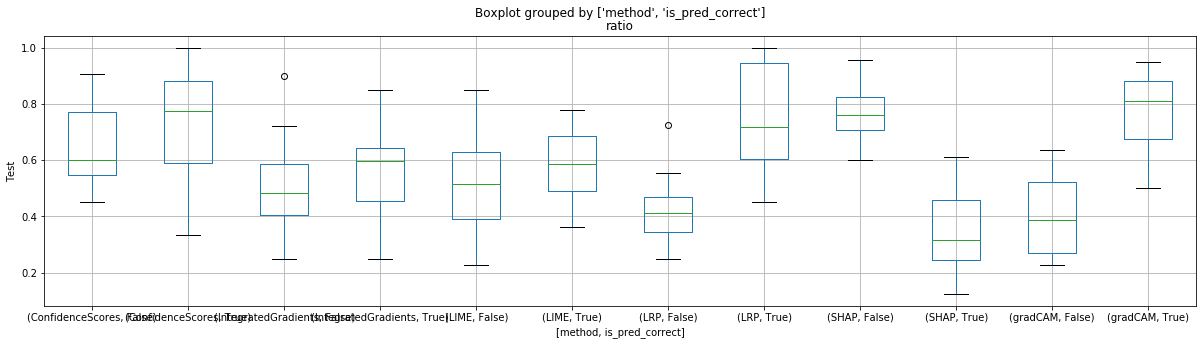

In [130]:
ax = df_ratios_qustn.boxplot(by=["method", "is_pred_correct"], column="ratio", figsize=(20, 5))
ax.set_ylabel("Test")

In [122]:
df_ratios_qustn

,QUESTNNR,method,is_pred_correct,response,ratio
0,bogen1,ConfidenceScores,False,False,0.772727
1,bogen1,ConfidenceScores,True,True,0.909091
2,bogen1,IntegratedGradients,False,False,0.409091
3,bogen1,IntegratedGradients,True,True,0.636364
4,bogen1,LIME,False,False,0.227273
...,...,...,...,...,...
139,bogen9,LRP,True,True,1.000000
140,bogen9,SHAP,False,False,0.800000
141,bogen9,SHAP,True,True,0.300000
142,bogen9,gradCAM,False,False,0.500000
